In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
%matplotlib inline

from torch.optim.lr_scheduler import StepLR

from model import NN
from model import save_model, load_model
from functions import uniform_circle_loss_function_method2, gaussian_loss_function
from train import training_routine
from train import testing_routine
from visuals import plot_transformed_grid_and_density, compute_uniform_circle_density, plot_transformed_circle_grid_and_density

from pathlib import Path

In [2]:
torch.set_default_dtype(torch.float64)
torch.manual_seed(2)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

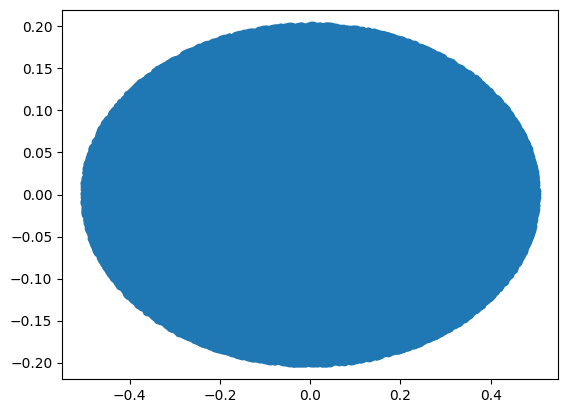

In [3]:
def generate_ellipse(max_num = 10000, scale=(0.5,0.2), device='cpu'):
    data = (torch.rand((max_num,2), device=device)-0.5)*2
    dist = torch.sum(torch.square(data),axis=1)
    data = data[torch.where(dist <= 1)]
    data *= torch.tensor(scale, device=device)
    return data

training_set = generate_ellipse(max_num=100000, scale=(0.5,0.2), device=device)
validation_set = generate_ellipse(max_num=10000, scale=(0.5,0.2), device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [4]:
model = NN(num_coupling_layers=30,layer_size=2, split_size_x1=1, nn_size=(1,10)).to(device)
model

NN(
  (layers): ModuleList(
    (0-29): 30 x CouplingLayer(
      (t_net): ModuleList(
        (0): Linear(in_features=1, out_features=10, bias=True)
        (1): Linear(in_features=10, out_features=10, bias=True)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
      (s_net): ModuleList(
        (0): Linear(in_features=1, out_features=10, bias=True)
        (1): Linear(in_features=10, out_features=10, bias=True)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
      (activation): ReLU()
    )
  )
  (rotation): Rotation()
)

In [5]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.98)
num_epoch = 20

In [6]:
%%time

for epoch in range(num_epoch):
    print(epoch)
    training_routine(model, train_loader, optimizer, uniform_circle_loss_function_method2) 
    print(testing_routine(model, validation_loader, uniform_circle_loss_function_method2))
    scheduler.step()

0


77it [00:11,  6.73it/s]
62it [00:02, 30.36it/s]


tensor(3293.5414, device='cuda:0')
1


77it [00:09,  8.20it/s]
62it [00:02, 30.50it/s]


tensor(-2149.9427, device='cuda:0')
2


77it [00:09,  8.15it/s]
62it [00:02, 30.39it/s]


tensor(-7470.0862, device='cuda:0')
3


77it [00:09,  8.23it/s]
62it [00:01, 31.28it/s]


tensor(-12023.5602, device='cuda:0')
4


77it [00:09,  8.18it/s]
62it [00:02, 30.05it/s]


tensor(-15596.3591, device='cuda:0')
5


77it [00:09,  8.44it/s]
62it [00:01, 31.31it/s]


tensor(-17599.8609, device='cuda:0')
6


77it [00:09,  8.17it/s]
62it [00:02, 30.94it/s]


tensor(-17881.1075, device='cuda:0')
7


77it [00:09,  8.12it/s]
62it [00:02, 30.69it/s]


tensor(-18020.9372, device='cuda:0')
8


77it [00:09,  8.21it/s]
62it [00:02, 29.84it/s]


tensor(-18104.2235, device='cuda:0')
9


77it [00:08,  8.56it/s]
62it [00:02, 30.91it/s]


tensor(-18165.8606, device='cuda:0')
10


77it [00:09,  8.22it/s]
62it [00:02, 30.97it/s]


tensor(-18206.3271, device='cuda:0')
11


77it [00:09,  8.19it/s]
62it [00:01, 31.99it/s]


tensor(-18262.7534, device='cuda:0')
12


77it [00:09,  8.16it/s]
62it [00:01, 31.20it/s]


tensor(-18299.6887, device='cuda:0')
13


77it [00:09,  8.13it/s]
62it [00:01, 31.42it/s]


tensor(-18320.0997, device='cuda:0')
14


77it [00:09,  8.15it/s]
62it [00:02, 30.94it/s]


tensor(-18353.1806, device='cuda:0')
15


77it [00:09,  8.09it/s]
62it [00:01, 31.55it/s]


tensor(-18369.6463, device='cuda:0')
16


77it [00:09,  8.08it/s]
62it [00:02, 30.47it/s]


tensor(-18383.4841, device='cuda:0')
17


77it [00:09,  8.08it/s]
62it [00:02, 30.68it/s]


tensor(-18407.8447, device='cuda:0')
18


77it [00:09,  8.16it/s]
62it [00:01, 31.28it/s]


tensor(-18400.0986, device='cuda:0')
19


77it [00:09,  8.18it/s]
62it [00:02, 30.41it/s]

tensor(-18429.5825, device='cuda:0')
CPU times: total: 4min 38s
Wall time: 3min 50s


0

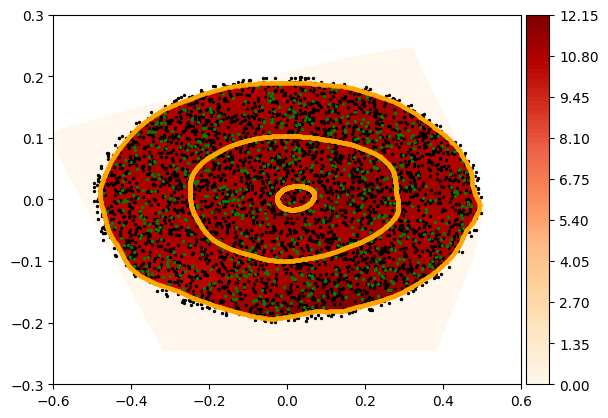

In [10]:
sampling_data = generate_ellipse(1000, (1, 1))

plot_transformed_circle_grid_and_density(model, training_set.to('cpu'), device, sampling_data, grid_shape=(1000,3),
                                             x_lim=(-0.6, 0.6), y_lim=(-0.3, 0.3),
                                             density_function=compute_uniform_circle_density, name='transformed_ellipse.png')

In [11]:
save_model(model, data = 'ellipse', checkpoint_number=1)
model_loaded = load_model(device=device, num_coupling_layers=30, layer_size=2, split_size_x1=1, nn_size=(1,10), path=f"./acl_uniform/ellipse/experiment{1}.pth")

Saved checkpoint: acl_uniform\ellipse\experiment99.pth


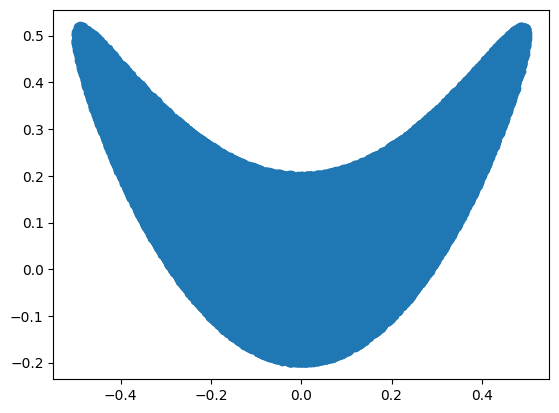

In [140]:
def generate_banana(n=100000, device=device):
    train_loader = generate_ellipse(n, device=device)
    train_loader[:, 1] = train_loader[:,1] + 2*train_loader[:,0]**2
    return train_loader
training_set = generate_banana(n=100000, device=device)
validation_set = generate_banana(n=10000, device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])
plt.savefig("banana.png")

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [19]:
model_banana = NN(num_coupling_layers=8,layer_size=2, split_size_x1=1, nn_size=(1,200)).to(device)

In [20]:
optimizer = torch.optim.SGD(model_banana.parameters(), lr=0.1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.98)
num_epoch = 20

In [21]:
%%time

for epoch in range(num_epoch):
    print(epoch)
    training_routine(model_banana, train_loader, optimizer, uniform_circle_loss_function_method2) 
    print(testing_routine(model_banana, validation_loader, uniform_circle_loss_function_method2))
    scheduler.step()

0


77it [00:04, 16.58it/s]
62it [00:00, 92.54it/s]


tensor(-8930.0408, device='cuda:0')
1


77it [00:04, 17.85it/s]
62it [00:00, 92.69it/s]


tensor(-13968.0124, device='cuda:0')
2


77it [00:04, 17.81it/s]
62it [00:00, 91.72it/s]


tensor(-15921.7889, device='cuda:0')
3


77it [00:04, 17.78it/s]
62it [00:00, 92.26it/s]


tensor(-16497.0481, device='cuda:0')
4


77it [00:04, 18.11it/s]
62it [00:00, 92.53it/s]


tensor(-17054.7031, device='cuda:0')
5


77it [00:04, 18.04it/s]
62it [00:00, 91.04it/s]


tensor(-17611.3705, device='cuda:0')
6


77it [00:04, 17.99it/s]
62it [00:00, 93.51it/s]


tensor(-17886.1849, device='cuda:0')
7


77it [00:04, 17.01it/s]
62it [00:00, 93.23it/s]


tensor(-17968.9631, device='cuda:0')
8


77it [00:04, 18.24it/s]
62it [00:00, 93.94it/s]


tensor(-18034.5731, device='cuda:0')
9


77it [00:04, 18.19it/s]
62it [00:00, 94.22it/s]


tensor(-18064.5323, device='cuda:0')
10


77it [00:04, 18.17it/s]
62it [00:00, 94.71it/s]


tensor(-18144.4277, device='cuda:0')
11


77it [00:04, 18.23it/s]
62it [00:00, 93.65it/s]


tensor(-18185.2860, device='cuda:0')
12


77it [00:04, 18.26it/s]
62it [00:00, 92.40it/s]


tensor(-18205.1563, device='cuda:0')
13


77it [00:04, 18.23it/s]
62it [00:00, 93.09it/s]


tensor(-18243.8464, device='cuda:0')
14


77it [00:04, 18.35it/s]
62it [00:00, 94.22it/s]


tensor(-18273.0701, device='cuda:0')
15


77it [00:04, 18.19it/s]
62it [00:00, 93.09it/s]


tensor(-18255.5774, device='cuda:0')
16


77it [00:04, 17.73it/s]
62it [00:00, 92.12it/s]


tensor(-18300.9511, device='cuda:0')
17


77it [00:04, 17.98it/s]
62it [00:00, 90.91it/s]


tensor(-18308.1411, device='cuda:0')
18


77it [00:04, 18.07it/s]
62it [00:00, 94.51it/s]


tensor(-18317.1608, device='cuda:0')
19


77it [00:04, 18.37it/s]
62it [00:00, 95.23it/s]

tensor(-18340.1055, device='cuda:0')
CPU times: total: 2min 29s
Wall time: 1min 39s


C:\Users\Admin\AppData\Local\Temp\ipykernel_14176\2117419962.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

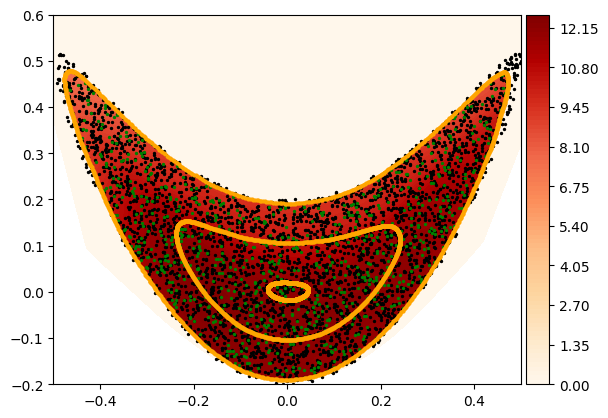

In [55]:
plot_transformed_circle_grid_and_density(model_banana, training_set.to('cpu'), device, sampling_data, grid_shape=(1000,3),
                                             x_lim=(-0.5, 0.5), y_lim=(-0.2, .6),
                                             density_function=compute_uniform_circle_density, name='transformed_banana.png')

In [12]:
save_model(model_banana, data = 'banana', checkpoint_number=1)
model_loaded = load_model(num_coupling_layers=8,layer_size=2, split_size_x1=1, nn_size=(1,200), path=f"./acl_uniform/banana/experiment{1}.pth")

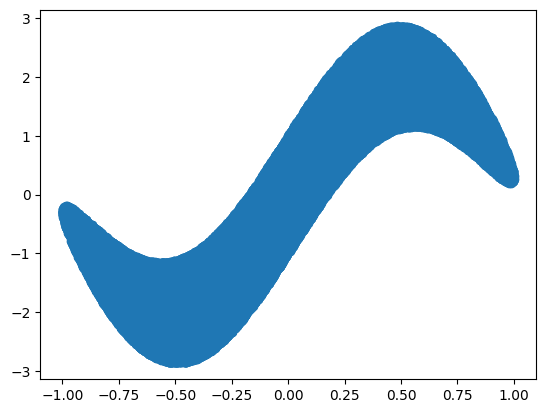

In [144]:
def generate_wave(n=100000, device='cpu'):
    train_loader = generate_ellipse(n, (1,1), device)
    train_loader[:, 1] = train_loader[:,1] + 2*torch.sin(3*train_loader[:,0])
    return train_loader
training_set = generate_wave(n=100000, device=device)
validation_set = generate_wave(n=10000, device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])
plt.savefig("wave.png")

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [26]:
model_wave = NN(num_coupling_layers=8,layer_size=2, split_size_x1=1, nn_size=(1,200)).to(device)

In [27]:
optimizer = torch.optim.SGD(model_wave.parameters(), lr=0.1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)
num_epoch = 20

In [28]:
%%time

for epoch in range(num_epoch):
    print(epoch)
    training_routine(model_wave, train_loader, optimizer, uniform_circle_loss_function_method2) 
    print(testing_routine(model_wave, validation_loader, uniform_circle_loss_function_method2))
    scheduler.step()

0


77it [00:04, 16.74it/s]
62it [00:00, 89.73it/s]


tensor(6502.9540, device='cuda:0')
1


77it [00:04, 18.16it/s]
62it [00:00, 93.51it/s]


tensor(4396.5262, device='cuda:0')
2


77it [00:04, 17.01it/s]
62it [00:00, 93.93it/s]


tensor(2890.0459, device='cuda:0')
3


77it [00:04, 17.24it/s]
62it [00:00, 94.51it/s]


tensor(2490.8289, device='cuda:0')
4


77it [00:04, 17.52it/s]
62it [00:00, 93.65it/s]


tensor(2312.0473, device='cuda:0')
5


77it [00:04, 18.31it/s]
62it [00:00, 93.80it/s]


tensor(2209.5713, device='cuda:0')
6


77it [00:04, 17.77it/s]
62it [00:00, 90.77it/s]


tensor(2101.3112, device='cuda:0')
7


77it [00:04, 18.21it/s]
62it [00:00, 93.79it/s]


tensor(2056.4977, device='cuda:0')
8


77it [00:04, 18.29it/s]
62it [00:00, 95.67it/s]


tensor(1954.7513, device='cuda:0')
9


77it [00:04, 18.32it/s]
62it [00:00, 92.53it/s]


tensor(1895.8041, device='cuda:0')
10


77it [00:04, 18.18it/s]
62it [00:00, 93.79it/s]


tensor(1849.0416, device='cuda:0')
11


77it [00:04, 18.16it/s]
62it [00:00, 91.71it/s]


tensor(1825.3943, device='cuda:0')
12


77it [00:04, 18.34it/s]
62it [00:00, 94.08it/s]


tensor(1794.2141, device='cuda:0')
13


77it [00:04, 18.18it/s]
62it [00:00, 93.51it/s]


tensor(1744.2216, device='cuda:0')
14


77it [00:04, 18.29it/s]
62it [00:00, 93.37it/s]


tensor(1746.2059, device='cuda:0')
15


77it [00:04, 18.33it/s]
62it [00:00, 94.65it/s]


tensor(1723.1249, device='cuda:0')
16


77it [00:04, 18.27it/s]
62it [00:00, 94.80it/s]


tensor(1682.8734, device='cuda:0')
17


77it [00:04, 18.29it/s]
62it [00:00, 94.22it/s]


tensor(1686.2462, device='cuda:0')
18


77it [00:04, 18.31it/s]
62it [00:00, 93.94it/s]


tensor(1637.2949, device='cuda:0')
19


77it [00:04, 18.36it/s]
62it [00:00, 94.51it/s]

tensor(1626.1136, device='cuda:0')
CPU times: total: 2min 30s
Wall time: 1min 38s


C:\Users\Admin\AppData\Local\Temp\ipykernel_14176\2117419962.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

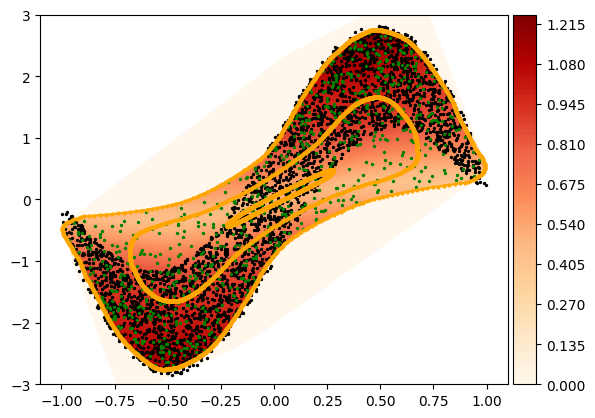

In [57]:
plot_transformed_circle_grid_and_density(model_wave, training_set.to('cpu'), device, sampling_data, grid_shape=(1000,3),
                                             x_lim=(-1.1, 1.1), y_lim=(-3, 3.),
                                             density_function=compute_uniform_circle_density, name='transformed_wave.png')

In [13]:
save_model(model_wave, data = 'wave', checkpoint_number=1)
model_loaded = load_model(num_coupling_layers=8,layer_size=2, split_size_x1=1, nn_size=(1,200), path=f"./acl_uniform/wave/experiment{1}.pth")

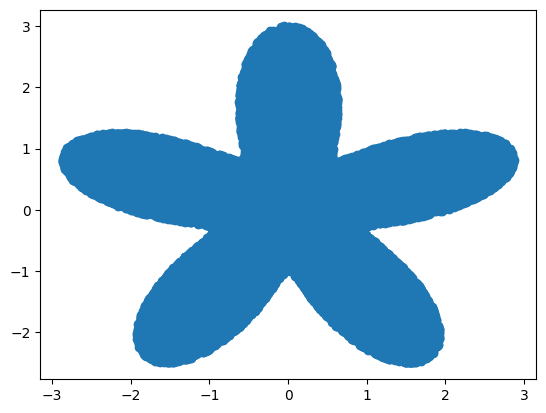

In [146]:
def generate_star(max_num = 10000, n_edges = 5, device='cpu'):
    data = generate_ellipse(max_num, scale=(3,3), device=device)
    angles = torch.arctan2(data[:,1],data[:,0])
    max_amplitude = torch.sin(n_edges*angles)+2
    amplitude = torch.sum(data**2,axis=1)**0.5
    data = data[amplitude <= max_amplitude]
    return data

training_set = generate_star(max_num=100000, n_edges=5, device=device)
validation_set = generate_star(max_num=10000, n_edges=5, device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])
plt.savefig("star.png")

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [35]:
model_star = NN(num_coupling_layers=8,layer_size=2, split_size_x1=1, nn_size=(1,200)).to(device)

In [36]:
optimizer = torch.optim.SGD(model_star.parameters(), lr=0.1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)
num_epoch = 20

In [39]:
%%time

for epoch in range(num_epoch):
    print(epoch)
    training_routine(model_star, train_loader, optimizer, uniform_circle_loss_function_method2) 
    print(testing_routine(model_star, validation_loader, uniform_circle_loss_function_method2))
    scheduler.step()

0


39it [00:05,  7.53it/s]
31it [00:00, 46.13it/s]


tensor(6717.4209, device='cuda:0')
1


39it [00:04,  8.75it/s]
31it [00:00, 46.75it/s]


tensor(6700.0409, device='cuda:0')
2


39it [00:04,  7.98it/s]
31it [00:00, 47.40it/s]


tensor(6684.0714, device='cuda:0')
3


39it [00:04,  8.79it/s]
31it [00:00, 47.91it/s]


tensor(6663.2290, device='cuda:0')
4


39it [00:04,  8.45it/s]
31it [00:00, 47.33it/s]


tensor(6647.8159, device='cuda:0')
5


39it [00:04,  8.87it/s]
31it [00:00, 47.47it/s]


tensor(6634.9990, device='cuda:0')
6


39it [00:04,  8.65it/s]
31it [00:00, 47.91it/s]


tensor(6622.9566, device='cuda:0')
7


39it [00:05,  7.49it/s]
31it [00:00, 48.29it/s]


tensor(6614.1001, device='cuda:0')
8


39it [00:04,  8.16it/s]
31it [00:00, 48.06it/s]


tensor(6605.1696, device='cuda:0')
9


39it [00:04,  8.08it/s]
31it [00:00, 41.33it/s]


tensor(6593.4690, device='cuda:0')
10


39it [00:04,  8.62it/s]
31it [00:00, 43.97it/s]


tensor(6585.6931, device='cuda:0')
11


39it [00:05,  7.57it/s]
31it [00:00, 46.90it/s]


tensor(6577.6777, device='cuda:0')
12


39it [00:04,  8.98it/s]
31it [00:00, 47.18it/s]


tensor(6570.0120, device='cuda:0')
13


39it [00:04,  8.17it/s]
31it [00:00, 45.59it/s]


tensor(6563.0277, device='cuda:0')
14


39it [00:04,  7.88it/s]
31it [00:00, 48.44it/s]


tensor(6557.2125, device='cuda:0')
15


39it [00:04,  8.26it/s]
31it [00:00, 47.99it/s]


tensor(6550.7816, device='cuda:0')
16


39it [00:04,  7.86it/s]
31it [00:00, 47.47it/s]


tensor(6545.2686, device='cuda:0')
17


39it [00:04,  8.83it/s]
31it [00:00, 48.21it/s]


tensor(6540.8646, device='cuda:0')
18


39it [00:04,  9.18it/s]
31it [00:00, 47.84it/s]


tensor(6536.0494, device='cuda:0')
19


39it [00:04,  8.27it/s]
31it [00:00, 44.73it/s]

tensor(6531.1124, device='cuda:0')
CPU times: total: 2min 37s
Wall time: 1min 47s


C:\Users\Admin\AppData\Local\Temp\ipykernel_14176\3763358807.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

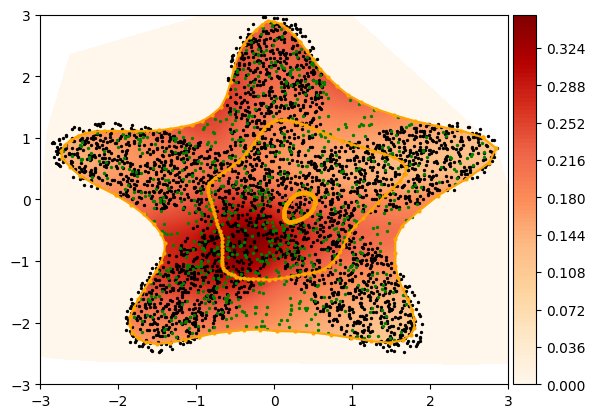

In [40]:
plot_transformed_circle_grid_and_density(model_star, training_set.to('cpu'), device, sampling_data, grid_shape=(100,3),
                                             x_lim=(-3, 3), y_lim=(-3, 3.),
                                             density_function=compute_uniform_circle_density)

In [14]:
save_model(model_star, data = 'star', checkpoint_number=1)
model_loaded = load_model(num_coupling_layers=8,layer_size=2, split_size_x1=1, nn_size=(1,200), path=f"./acl_uniform/star/experiment{1}.pth")